In [1]:
import collections
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import tqdm

from wordcloud import WordCloud, STOPWORDS

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");
    
class ReadStatus(object):
    READ = 'read'
    UNREAD = 'to-read'
    NEEDS_CLEAN = 'needs-clean'
    UNKNOWN = 'unknown'
    REFERENCE = 'reference'
    
    ALL = [READ, UNREAD, NEEDS_CLEAN, UNKNOWN, REFERENCE]
    VALID = [READ, UNREAD, NEEDS_CLEAN]

In [2]:
con = sqlite3.connect('/Users/nnayak/Zotero/zotero.sqlite')
cur = con.cursor()

cur.execute('''SELECT * FROM fields;''')
fields = {a:b for (a, b, _) in cur.fetchall()}
rev_fields = {name:idx for idx, name in fields.items()}

cur.execute('''SELECT * FROM tags;''')
tags = {a:b for (a, b) in cur.fetchall()}
rev_tags = {name:idx for idx, name in tags.items()}

In [3]:
class Paper(object):
    def __init__(self, paper_id, title, add_month):
        self.paper_id = paper_id
        self.tags = []
        self.add_month = add_month
        self.title = title
        self.read_status = ReadStatus.UNKNOWN
        self.valid = False
    
    def set_tags(self, tags):
        for tag in tags:
            if tag in ReadStatus.VALID:
                self.read_status = tag
            else:
                self.tags.append(tag)
        self.valid = True
        if 'semiotics' in self.tags:
            print(self.title)
        
    def to_dict(self):
        if not self.valid:
            return None
        assert len(self.tags)
        return {
            "paper_id":self.paper_id,
            "tags":self.tags,
            "add_month":self.add_month,
            "title":self.title,
            "read_status":self.read_status,
        }
    
def get_month_wordcloud(month_papers):
    tags = sum([paper.tags for paper in month_papers], [])
    if not tags:
        return
    wordcloud = WordCloud(
    width = 3000, height = 2000, random_state=1,
    background_color='salmon', colormap='Pastel1', collocations=False, stopwords = []).generate(
    " ".join(tags))
    plot_cloud(wordcloud)
        
        
def get_some_value(cursor, item_id, field_id):
    cur.execute(
        "SELECT valueID FROM itemData WHERE itemID = ? and fieldID = ?", (item_id, field_id))
    rows = cur.fetchall()
    if not rows:
        return None
    (field_value_id,) = rows[0]
    
    cur.execute("SELECT value FROM itemDataValues WHERE valueID =%s" % field_value_id)
    rows = cur.fetchall()
    if not rows:
        return None
    return rows[0][0]

def get_add_month(cur, item_id):
    cur.execute(
        "SELECT dateAdded FROM items WHERE itemID = ? ", (item_id,))
    rows = cur.fetchall()
    assert len(rows) == 1
    return rows[0][0][:7]
         
paper_map = {}
tag_map = collections.defaultdict(list)
cur.execute('''SELECT * FROM itemTags;''')

for i in cur.fetchall():
    item_id, tag_id, _ = i
    
    title = get_some_value(cur, item_id, rev_fields['title'])
    add_month = get_add_month(cur, item_id)
    if item_id not in paper_map:
        paper_map[item_id] = Paper(item_id, title, add_month)
    tag_map[item_id].append(tags[tag_id])

con.close()
    
dup_counter = collections.Counter(str(p.title) for p in paper_map.values())
for k, v in dup_counter.items():
    if v == 1:
        continue
    else:
        print(v, k)
    
for paper_id, paper_obj in paper_map.items():
    paper_map[paper_id].set_tags(tag_map[paper_id])

papers_by_month = collections.defaultdict(list)
for paper_id, paper in paper_map.items():
    papers_by_month[paper.add_month].append(paper)
    
    

2 Neha_LabMeetingApril2021_condensed.pdf


In [4]:
# Things by month

dicts = []

def tag_counter(paper_list):
    counter = collections.Counter()
    for paper in paper_list:
        counter.update(paper.tags)
    return dict(counter)

for month, papers in papers_by_month.items():
    dict_starter = tag_counter(papers)
    dict_starter["month"] = month
    dicts.append(dict_starter)

<AxesSubplot:xlabel='month'>

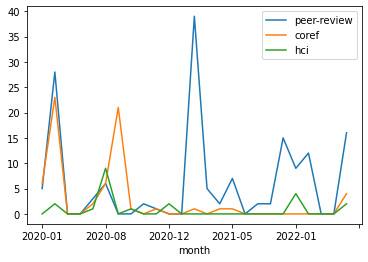

In [5]:
k = pd.DataFrame(dicts,).fillna(0)

k.plot.line(x='month', y=("peer-review coref hci"
                          "").split())

In [6]:
# Read to unread ratio

counters = collections.defaultdict(lambda : collections.Counter())

for paper in paper_map.values():
    for tag in paper.tags:
        counters[tag][paper.read_status] += 1
        
        
dicts = []

for tag, counts in counters.items():
    total = sum(counts.values())
    if total <= 5:
        continue
    dicts.append({
        "tag": tag,
        ReadStatus.UNREAD: counts[ReadStatus.UNREAD],
        ReadStatus.READ: counts[ReadStatus.READ],
        "read_proportion":  counts[ReadStatus.READ] / total,
        "total": total
    })
        

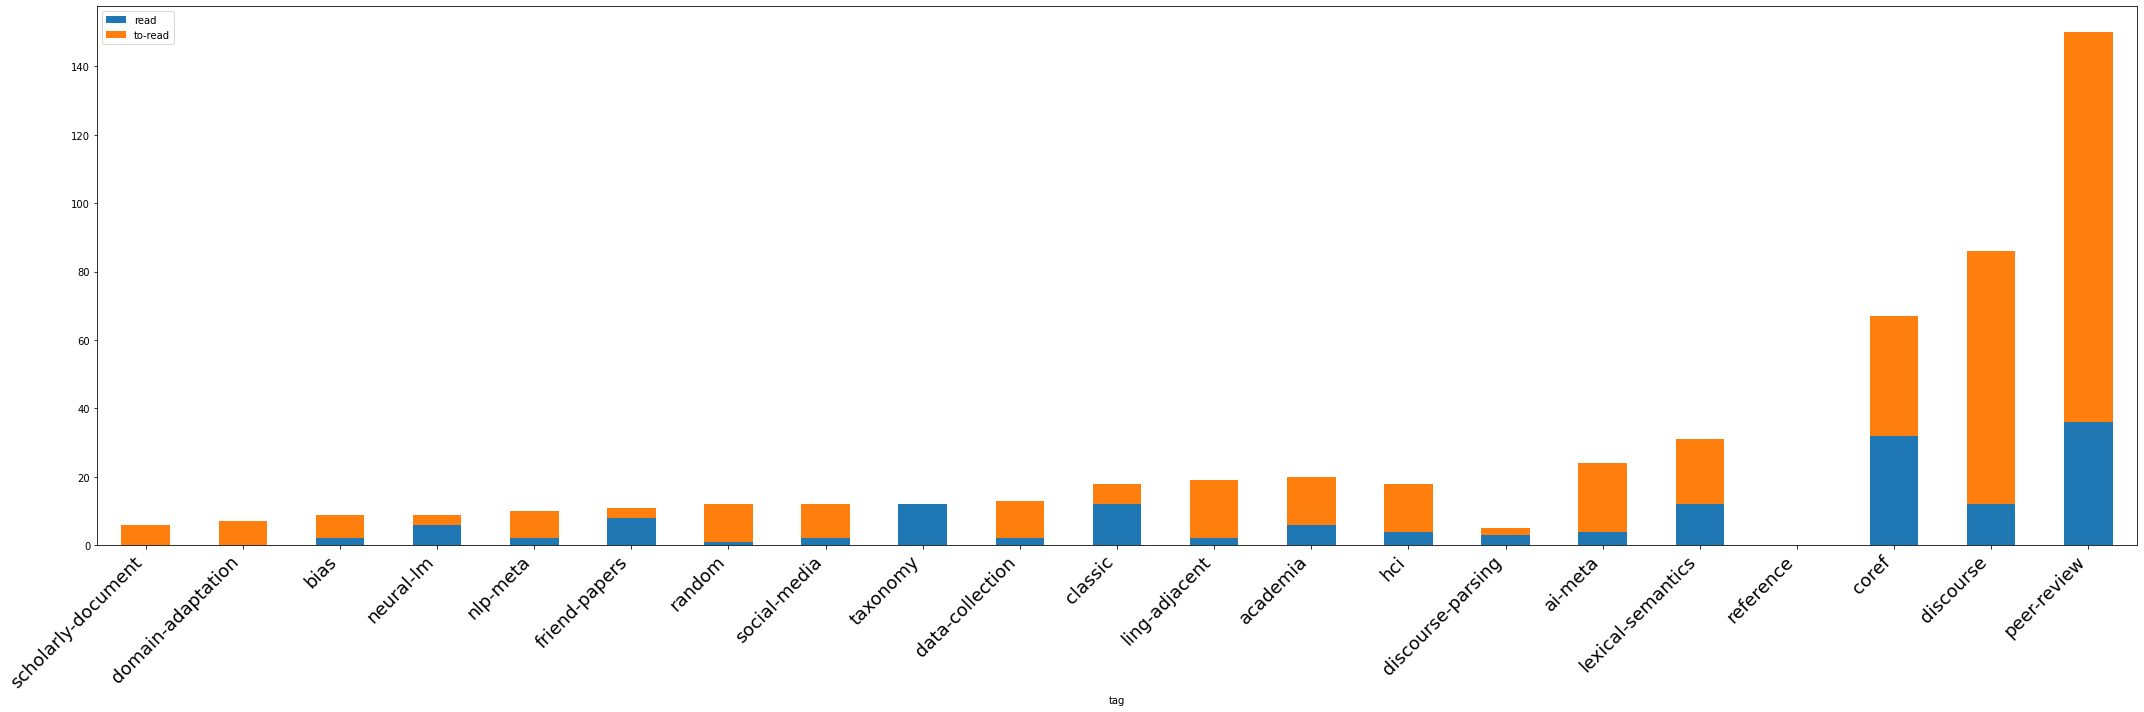

In [7]:
k = pd.DataFrame(dicts).sort_values("total")
k.plot.bar(stacked=True, y=[ReadStatus.READ, ReadStatus.UNREAD], x="tag", figsize=(30,10))
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.tight_layout()



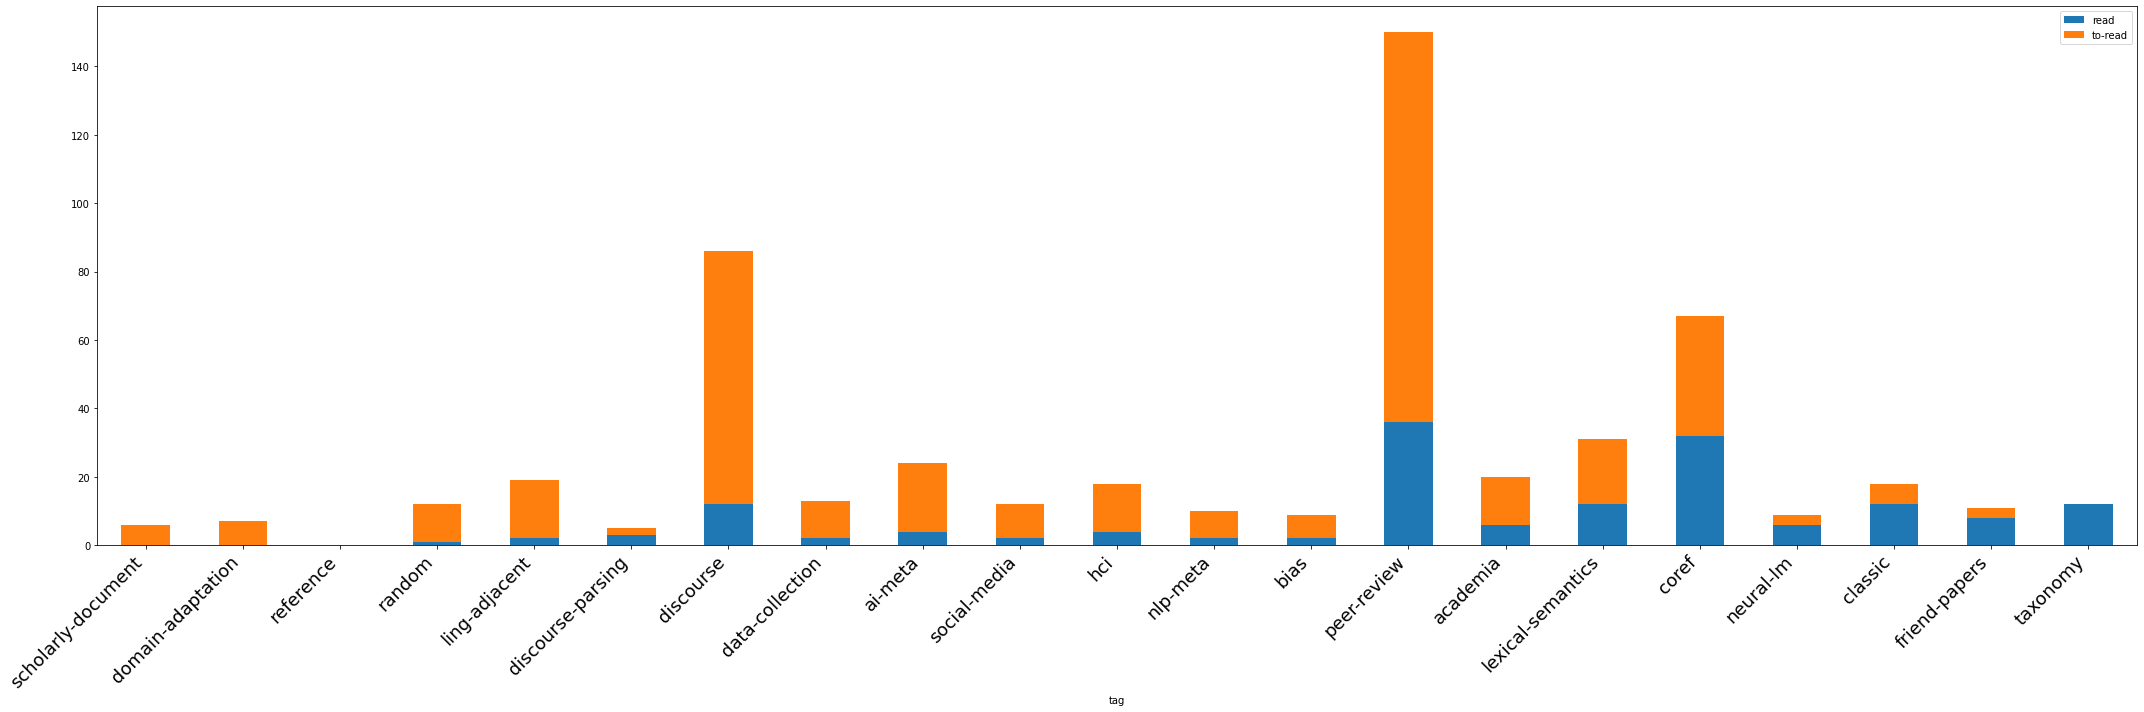

In [8]:

k = pd.DataFrame(dicts).sort_values("read_proportion")
k.plot.bar(stacked=True, y=[ReadStatus.READ, ReadStatus.UNREAD], x="tag", figsize=(30,10))
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.tight_layout()

In [9]:
# Read to unread ratio

counters = collections.defaultdict(lambda : collections.Counter())

for paper in paper_map.values():
    for tag in paper.tags:
        counters[tag][paper.read_status] += 1
        
        
dicts = []

for tag, counts in counters.items():
    total = sum(counts.values())
    if total > 5:
        continue
    dicts.append({
        "tag": tag,
        ReadStatus.UNREAD: counts[ReadStatus.UNREAD],
        ReadStatus.READ: counts[ReadStatus.READ],
        "read_proportion":  counts[ReadStatus.READ] / total,
        "total": total
    })


k = pd.DataFrame(dicts).sort_values("total")

k.to_csv("few_papers.tsv", sep='\t')

In [10]:
pd.set_option('display.max_rows', 100)

In [11]:
k

,tag,to-read,read,read_proportion,total
11,zmini-cultural-analytics,1,1,0.500000,2
21,ssc,1,1,0.500000,2
2,zmini-common-sense,0,2,1.000000,2
18,weak-sup,1,1,0.500000,2
16,soc-sci-systems,2,0,0.000000,2
7,zmini-hedging,2,0,0.000000,2
15,zmini-humor,0,2,1.000000,2
10,zmini-causal-inference,2,0,0.000000,2
19,cross-document,2,1,0.333333,3
17,temp,3,0,0.000000,3


In [12]:
tag_counter = collections.Counter()

for paper_id, paper_obj in paper_map.items():
  for tag in paper_obj.tags:
    tag_counter[tag] += 1
    
for k, v in tag_counter.most_common():
  print(f'{k}\t{v}')

peer-review	154
discourse	90
coref	67
reference	34
lexical-semantics	31
ai-meta	24
discourse-parsing	23
hci	21
academia	20
ling-adjacent	19
classic	18
data-collection	13
social-media	12
taxonomy	12
random	12
friend-papers	11
nlp-meta	10
neural-lm	9
bias	9
domain-adaptation	7
scholarly-document	6
document-level	5
qual-interviewing	5
zmini-factuality	4
proj-hnds	4
interpretable	4
zmini-logic	4
classwork	4
discourse-segmentation	4
skimmed	3
probing	3
zmini-summarization	3
zmini-relation-extraction	3
my-papers	3
temp	3
cross-document	3
sociology	3
zmini-common-sense	2
zmini-hedging	2
zmini-causal-inference	2
zmini-cultural-analytics	2
zmini-humor	2
soc-sci-systems	2
weak-sup	2
ssc	2
